In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from keras.models import load_model
import pandas as pd

In [15]:
gan_samples = xr.open_dataset("../exp/gan_gen_patches_0000_epoch_0010.nc")

In [16]:
patches = gan_samples["gen_patch"][:, :, 0]

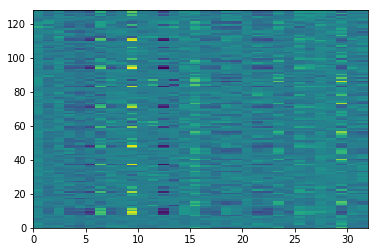

In [17]:
plt.pcolormesh(patches)

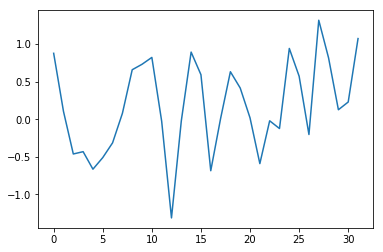

In [5]:
plt.plot(patches[34])

(array([  4.,   3.,   4.,   9.,   8.,  15.,  53.,  22.,   3.,   7.]),
 array([-0.31012926, -0.23490413, -0.15967901, -0.08445388, -0.00922876,
         0.06599636,  0.14122149,  0.21644661,  0.29167174,  0.36689686,
         0.44212198]),
 <a list of 10 Patch objects>)

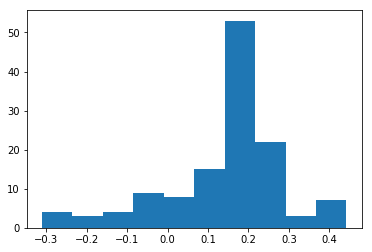

In [6]:
plt.hist(patches.mean(axis=1))

In [18]:
gan_loss = pd.read_csv("../exp/gan_loss_history_0000.csv", index_col="Time")

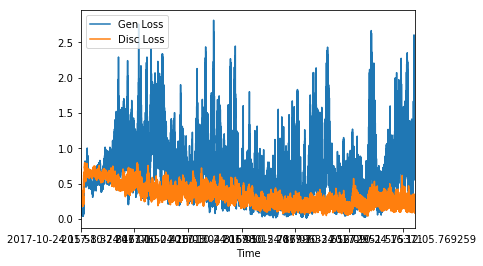

In [20]:
gan_loss[["Gen Loss", "Disc Loss"]].plot()

In [21]:
combined_data = pd.read_csv("../exp/lorenz_combined_output.csv")

In [27]:
y_cols = combined_data.columns[combined_data.columns.str.contains("Y")]
x_cols = combined_data.columns[combined_data.columns.str.contains("X")]
print(y_cols)
print(x_cols)

Index(['Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9',
       'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14', 'Y_15', 'Y_16', 'Y_17', 'Y_18',
       'Y_19', 'Y_20', 'Y_21', 'Y_22', 'Y_23', 'Y_24', 'Y_25', 'Y_26', 'Y_27',
       'Y_28', 'Y_29', 'Y_30', 'Y_31'],
      dtype='object')
Index(['X_t', 'X_t-1', 'X_t-2'], dtype='object')


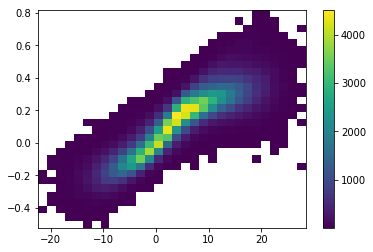

In [36]:
_ = plt.hist2d(combined_data["X_t"], combined_data[y_cols].mean(axis=1), bins=[30, 30], cmin=1)
plt.colorbar()

In [30]:
np.corrcoef(combined_data[x_cols].values.T)

array([[ 1.        ,  0.99993999,  0.99976   ],
       [ 0.99993999,  1.        ,  0.99993999],
       [ 0.99976   ,  0.99993999,  1.        ]])

(array([  7.00000000e+00,   1.60000000e+01,   4.70000000e+01,
          1.30000000e+02,   3.67000000e+02,   7.78000000e+02,
          1.78400000e+03,   3.58000000e+03,   7.26300000e+03,
          1.44630000e+04,   3.07250000e+04,   5.53350000e+04,
          3.42270000e+04,   1.89400000e+04,   1.15790000e+04,
          7.47000000e+03,   4.92500000e+03,   3.15500000e+03,
          2.01900000e+03,   1.19000000e+03,   7.45000000e+02,
          4.08000000e+02,   2.27000000e+02,   1.25000000e+02,
          5.30000000e+01,   2.80000000e+01,   9.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 array([-0.83930373, -0.76956189, -0.69982006, -0.63007822, -0.56033638,
        -0.49059455, -0.42085271, -0.35111087, -0.28136903, -0.2116272 ,
        -0.14188536, -0.07214352, -0.00240169,  0.06734015,  0.13708199,
         0.20682383,  0.27656566,  0.3463075 ,  0.41604934,  0.48579117,
         0.55553301,  0.62527485,  0.69501669,  0.76475852,  0.83450036,
         0.90

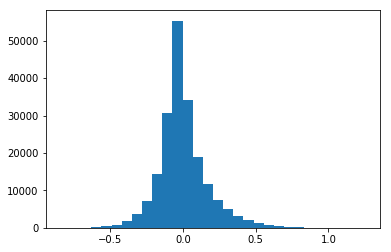

In [39]:
plt.hist(combined_data["X_t-2"] - combined_data["X_t"], bins=30)

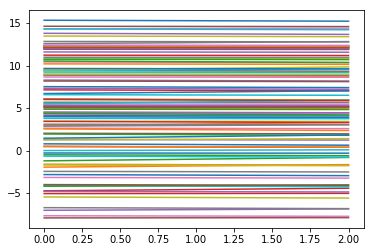

In [43]:
plt.plot(combined_data.loc[:100, x_cols].values.T)

In [45]:
lorenz_series = xr.open_dataset("../exp/lorenz_output.nc")

In [61]:
x_values = lorenz_series["lorenz_x"][:, 0].to_dataframe()

In [91]:
lags = np.arange(5, 2001, 5)
auto_corr = np.zeros(lags.size)
for l, lag in enumerate(lags):
    auto_corr[l] = x_values["lorenz_x"].autocorr(lag)

In [94]:
auto_corr[:5]

array([ 0.99849999,  0.99401533,  0.98659175,  0.97630433,  0.96325586])

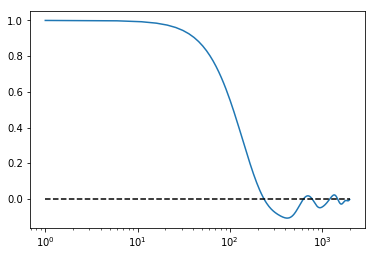

In [89]:
plt.plot(lags, auto_corr)
plt.plot(lags, np.zeros(lags.size), 'k--')
plt.gca().set_xscale("log")

In [114]:
x_values["lorenz_x"].values[1000::5]

array([ 7.35938501,  7.64667892,  7.96005154, ...,  2.92966819,
        3.04421759,  3.16192937])

(array([  3.30000000e+01,   2.04000000e+02,   1.23100000e+03,
          4.92500000e+03,   1.70230000e+04,   6.69190000e+04,
          7.71400000e+04,   1.08750000e+04,   1.51200000e+03,
          1.21000000e+02]),
 array([-8.38181484, -6.95794361, -5.53407238, -4.11020114, -2.68632991,
        -1.26245868,  0.16141255,  1.58528378,  3.00915501,  4.43302624,
         5.85689747]),
 <a list of 10 Patch objects>)

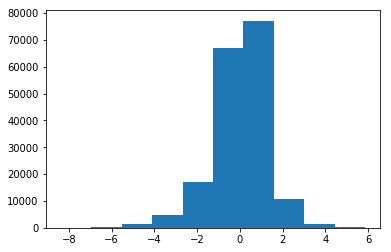

In [107]:
plt.hist(x_values["lorenz_x"].values[100:900015:5] - x_values["lorenz_x"].values[85:900000:5])

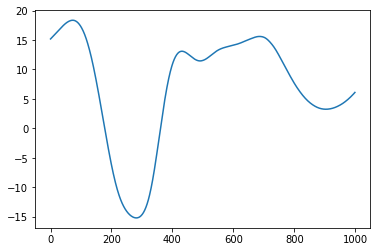

In [80]:
plt.plot(np.arange(1000), x_values.iloc[2000:3000, 1])

In [72]:
x_values.shape

(998001, 2)

(array([   126.,    180.,    565.,   1918.,   3632.,   7844.,  13770.,
         20660.,  29019.,  38926.,  47854.,  56198.,  64737.,  70152.,
         74519.,  79949.,  80543.,  74487.,  68967.,  57388.,  53141.,
         44603.,  37308.,  26730.,  19603.,  12166.,   8157.,   3743.,
           928.,    188.]),
 array([-3.3311972 , -3.12129442, -2.91139164, -2.70148886, -2.49158608,
        -2.2816833 , -2.07178052, -1.86187774, -1.65197496, -1.44207218,
        -1.2321694 , -1.02226662, -0.81236384, -0.60246106, -0.39255828,
        -0.1826555 ,  0.02724728,  0.23715006,  0.44705284,  0.65695562,
         0.8668584 ,  1.07676118,  1.28666396,  1.49656674,  1.70646952,
         1.9163723 ,  2.12627508,  2.33617786,  2.54608064,  2.75598342,
         2.9658862 ]),
 <a list of 30 Patch objects>)

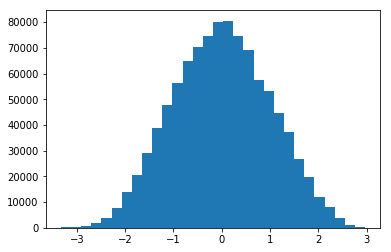

In [84]:
plt.hist((x_values["lorenz_x"] - x_values["lorenz_x"].mean()) / x_values['lorenz_x'].std(), 30)

In [115]:
all_x = lorenz_series["lorenz_x"].values

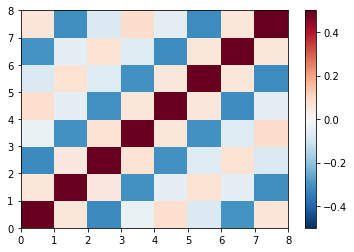

In [122]:
plt.pcolor(np.corrcoef(all_x.T), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.colorbar()